In [19]:
# Import modules

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # Import PercentFormatter


In [3]:
# Load data
# data = pd.read_csv('data.csv')
data = pd.read_csv('data\planning_historic_actuals.csv')
data_4hrs = data[((data['MeasureID'] == 3162) | (data['MeasureID'] == 3163)) & (data['RegionCode'] == "Y59")]

# Unpivot data
data_4hrs = pd.melt(data_4hrs, id_vars=data_4hrs.columns[1:7], value_vars=data_4hrs.columns[8:])

# Pivot again...
data_4hrs = data_4hrs.pivot_table(index=['variable'],
                                    columns='MeasureType', values='value').reset_index()

# Rename month column, filter error months, and set data type to date
data_4hrs.rename(columns={'variable': 'date'}, inplace=True)
data_4hrs = data_4hrs.loc[data_4hrs['date'].str.len() == 6]
data_4hrs['date'] = pd.to_datetime(data_4hrs['date'], format='%b-%y')

# Calculate measure
data_4hrs['value'] = data_4hrs['Total Attendances < 4 hours (All Type)'] / data_4hrs['Total attendances (All Type)']

# Keep only relevant columns and set index
data_4hrs = data_4hrs[['date', 'value']].set_index('date')

data_4hrs.head()

MeasureType,value
date,
2024-04-01,0.973177
2023-08-01,0.983721
2024-08-01,0.987749
2023-12-01,0.977529
2024-12-01,0.978886


In [4]:
# Load plan data
plan = pd.read_csv('data/plans.csv')

plan = plan[plan['planning_ref'] == "E.M.13"] # E.M.13, 4hrs

data_4hrs_plan = plan.groupby(['dimension_name']).agg({'numerator': 'sum', 'denominator': 'sum'}).reset_index()

# Calculate performance measure
data_4hrs_plan['plan'] = data_4hrs_plan['numerator'] / data_4hrs_plan['denominator']

data_4hrs_plan = data_4hrs_plan.rename(columns={'dimension_name': 'date'})
data_4hrs_plan['date'] = pd.to_datetime(data_4hrs_plan['date'], format='%d/%m/%Y')

# # Change date to end of month to match actuals
# data_4hrs_plan['date'] = data_4hrs_plan['date'] + pd.offsets.MonthEnd(0)

data_4hrs_plan.head()

,date,numerator,denominator,plan
0,2026-01-01,773044.0,1005709.0,0.768656
1,2026-02-01,750417.0,959525.0,0.782071
2,2026-03-01,852658.0,1059060.0,0.805108
3,2025-04-01,748495.0,978349.0,0.765059
4,2025-05-01,804636.0,1045480.0,0.769633


In [5]:
# Sum value to region total
data_4hrs_actual = data_4hrs.groupby('date')['value'].sum().reset_index()

# Remove 'zero' data
data_4hrs_actual = data_4hrs_actual[data_4hrs_actual['value'] != 0]

In [6]:
# merge data
data_4hrs_plan = pd.merge(data_4hrs_actual, data_4hrs_plan, on='date', how='outer')

data_4hrs_plan = data_4hrs_plan[['date', 'plan']]

# Change date to end of month to match actuals
data_4hrs_plan['date'] = data_4hrs_plan['date'] + pd.offsets.MonthEnd(0)

data_4hrs_plan.head()

,date,plan
0,2023-05-31,NaN
1,2023-06-30,NaN
2,2023-07-31,NaN
3,2023-08-31,NaN
4,2023-09-30,NaN


In [ ]:
print(data_52wks_forecast.columns)

Index(['date', 'value', 'plan'], dtype='object')


In [24]:
# Check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_4hrs_forecast['value'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, data is non-stationary, so we need to difference it
if result[1] > 0.05:
    data_4hrs_forecast['value'] = data_4hrs_forecast['value'].diff().dropna()
    data_4hrs_forecast = data_4hrs_forecast.dropna()

ADF Statistic: -2.4534121175220593
p-value: 0.12722491050476092


c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\base\model.py:607:

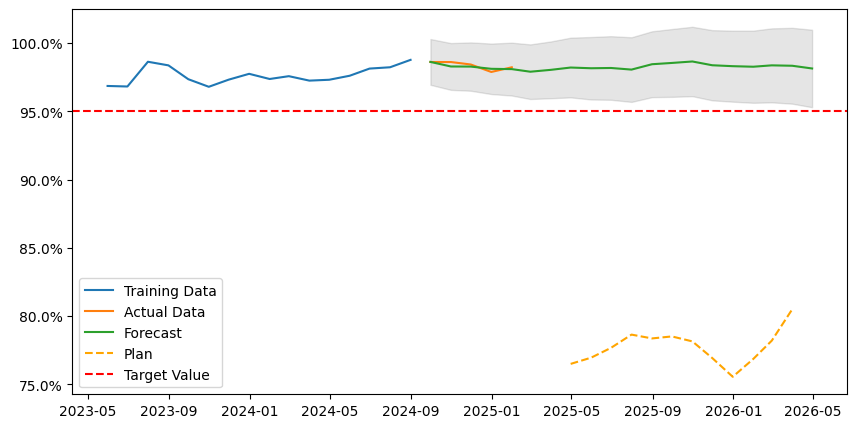

Probability of hitting the target by 2026-03-31: 0.00%
Last date in training data: 2024-08-31 00:00:00


In [25]:
data_4hrs_forecast = data_4hrs_actual

# Ensure the date column is parsed as datetime and set as index
# data_52wks_forecast['date'] = pd.to_datetime(data_52wks_forecast['date'])
data_4hrs_forecast = data_4hrs_forecast.set_index('date')

# Ensure data is in monthly frequency
data_4hrs_forecast = data_4hrs_forecast.resample('M').mean()

# Combine the date ranges from forecast and plan
combined_dates = data_4hrs_forecast.index.union(data_4hrs_plan['date'])

# Reindex data_4hrs_forecast to include all dates in the combined range
data_4hrs_forecast = data_4hrs_forecast.reindex(combined_dates)

# Reset plan index to match forecast index
data_4hrs_plan = data_4hrs_plan.set_index('date').reindex(data_4hrs_forecast.index).reset_index()

# Select the column to use for ARIMA model
endog = data_4hrs_forecast['value']

# Define the target date and value
target_date = '2026-03-31'
target_value = 0.95 # NHS 4 hour target

# Split data into training and testing sets
# Find the length of data_4hrs_forecast ignoring missing values
length = len(data_4hrs_forecast.dropna())
train = data_4hrs_forecast[:int(0.8*length)]
test = data_4hrs_forecast[int(0.8*length):]

# Fit ARIMA model
model = ARIMA(endog, order=(15,1,0))
model_fit = model.fit()

# Forecast up to the target date
forecast_steps = len(pd.date_range(start=train.index[-1], end=target_date, freq='M'))
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(train.index, train['value'], label='Training Data')
plt.plot(test.index, test['value'], label='Actual Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
# Plot the plan data from data_4hrs_plan
plt.plot(data_4hrs_plan['date'], data_4hrs_plan['plan'], label='Plan', color='orange', linestyle='--')

plt.axhline(y=target_value, color='r', linestyle='--', label='Target Value')

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Scale values to percentage

# plt.plot(data_52wks_forecast.index, data_52wks_forecast['plan'], label='Plan', color='orange')
plt.legend()
plt.show()

# Calculate probability of hitting target on the target date
target_conf_int = conf_int.iloc[-1]  # Confidence interval on the target date
probability = np.mean((target_conf_int[0] <= target_value) & (target_conf_int[1] >= target_value))
print(f'Probability of hitting the target by {target_date}: {probability*100:.2f}%')

print("Last date in training data:", train.index[-1])